<a href="https://colab.research.google.com/github/cfreeman22/predictive_modeling_mlr/blob/main/D208_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from patsy import dmatrices

from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from scipy.stats import *
# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import statsmodels.api as sm 
import pylab as py 
sns.set(color_codes= True)
# to compute ttest
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
# To get diferent metric scores
# To get diferent metric scores

# Library to split data
from sklearn.model_selection import train_test_split

 

In [3]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(6, 4), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [4]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [5]:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [6]:
# functions to treat outliers by flooring and capping


def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [7]:
#reading the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Reading the data from my google drive.
df = pd.read_csv('/content/drive/My Drive/churn_clean.csv')

# **Data Preparation**
## **Research question: Using multiple regression, can we predict bandwidth usage based on other variables in the churn dataset?**

In [9]:
#data info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [10]:
# Checking for duplicates
df.duplicated().sum()

0

In [11]:
df.isnull().values.any()

False

In [12]:
#Checking for null
df.isna().sum()

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [13]:
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,Job,Children,Age,Income,Marital,Gender,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,Urban,America/Sitka,Environmental health practitioner,0,68,28561.99,Widowed,Male,No,7.978323,10,0,1,No,One year,Yes,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Credit Card (automatic),6.795513,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,Urban,America/Detroit,"Programmer, multimedia",1,27,21704.77,Married,Female,Yes,11.699080,12,0,1,Yes,Month-to-month,No,Yes,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Bank Transfer(automatic),1.156681,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,Urban,America/Los_Angeles,Chief Financial Officer,4,50,9609.57,Widowed,Female,No,10.752800,9,0,1,Yes,Two Year,Yes,No,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes,Credit Card (automatic),15.754144,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,Suburban,America/Los_Angeles,Solicitor,1,48,18925.23,Married,Male,No,14.913540,15,2,0,Yes,Two Year,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes,Mailed Check,17.087227,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,Suburban,America/Chicago,Medical illustrator,0,83,40074.19,Separated,Male,Yes,8.147417,16,2,1,No,Month-to-month,Yes,No,Fiber Optic,No,No,No,No,No,Yes,Yes,No,No,Mailed Check,1.670972,149.948316,271.493436,4,4,4,3,4,4,4,5


### Descriptive statistics

In [14]:
df.describe(include= 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CaseOrder,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
Customer_id,10000,10000,K409198,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interaction,10000,10000,aa90260b-4141-4a24-8e36-b04ce1f4f77b,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UID,10000,10000,e885b299883d4f9fb18e39c75155d990,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,10000,6058,Houston,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,10000,52,TX,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
County,10000,1620,Washington,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip,10000.0,NaN,NaN,NaN,49153.3196,27532.196108,601.0,26292.5,48869.5,71866.5,99929.0
Lat,10000.0,NaN,NaN,NaN,38.757567,5.437389,17.96612,35.341828,39.3958,42.106908,70.64066
Lng,10000.0,NaN,NaN,NaN,-90.782536,15.156142,-171.68815,-97.082812,-87.9188,-80.088745,-65.66785


### **Observation for the descriptive statistics**
- There are 50 columns and 10000 rows in the churn dataset
- CaseOrder, Customer_id,	Interaction, UID, Zip,	Lat,	Lng, TimeZone	do not provide any added value for our analysis. They mainly serve the prpose of identificatiion and canot be used as  continuous variables
- City, State, county and Job have unique values of 6058, 52,1620 and 639  respectively. Using them in our analysis will increase the number of columns and create more dimensions in the data set. The population column might not be useful simply b ecause it is hard to associate a population number to a single row that represents only one customer.
- The above mentioned columns (13 in total) will be dropped bringing the remaining columns to 37. 
- The dataset does not have any null, NaNs or duplicated values
- After cleaning , we are left with 19 categorical variables in the data set. Dummy variables will be created for these categorical columns as part of the transformation process. 18 numercical variables were left including the target variable Bandwidth_GB_Year. From the the previous project, this column was identified as being a U-shaped distribution.
- Full statistical analysis of all variables will be discussed in C4 below 

### **Steps used to Prepare Data.**
- imported the necessary libraries and defined custom functions for data manipulation
- identified and dropped unnecessary columns
- Rename the survey response features (8 columns items total) for better data labeling
- Observed descriptive statistics of the remaining data frame
- checked for nulls, duplicates, and other anomalies
- Extract categorical variables into a list and print summary statistics
- Performed univariate and bivariate visualizations
- created dummy variables for categorical data
- Made a copy of the prepared dataset and save it to csv file

#### **Dropping unnecessary columns and renaming response columns**





In [15]:

# Dropping unnecessary columns
cols_to_drop =['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'Zip', 'Lat', 'Lng', 'TimeZone','City', 'State', 'County','Job','Population' ]

# Dropping unnecessary columns
df = df.drop(cols_to_drop, axis = 1)

# renaming the survey items columns
df = df.rename(columns={'Item1': 'TimelyResponse','Item2': 'TimelyFixes' , 'Item3': 'TimelyReplacements', 'Item4': 'Reliability',

                          'Item5': 'Options', 'Item6': 'RespectfulResponse', 'Item7': 'CourteousExchange', 'Item8': 'ActiveListening'})

# Checking to confirm if unnecessary columns were dropped and survey columns renamed appropriately

df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  10000 non-null  object 
 1   Children              10000 non-null  int64  
 2   Age                   10000 non-null  int64  
 3   Income                10000 non-null  float64
 4   Marital               10000 non-null  object 
 5   Gender                10000 non-null  object 
 6   Churn                 10000 non-null  object 
 7   Outage_sec_perweek    10000 non-null  float64
 8   Email                 10000 non-null  int64  
 9   Contacts              10000 non-null  int64  
 10  Yearly_equip_failure  10000 non-null  int64  
 11  Techie                10000 non-null  object 
 12  Contract              10000 non-null  object 
 13  Port_modem            10000 non-null  object 
 14  Tablet                10000 non-null  object 
 15  InternetService     

In [16]:
df.InternetService.value_counts()

Fiber Optic    4408
DSL            3463
None           2129
Name: InternetService, dtype: int64

#### **Describtive statistics**

In [17]:
# Descriptive statistics of numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Children,10000.0,2.087700,2.147200,0.000000,0.000000,1.000000,3.000000,10.000000
Age,10000.0,53.078400,20.698882,18.000000,35.000000,53.000000,71.000000,89.000000
Income,10000.0,39806.926771,28199.916702,348.670000,19224.717500,33170.605000,53246.170000,258900.700000
Outage_sec_perweek,10000.0,10.001848,2.976019,0.099747,8.018214,10.018560,11.969485,21.207230
Email,10000.0,12.016000,3.025898,1.000000,10.000000,12.000000,14.000000,23.000000
Contacts,10000.0,0.994200,0.988466,0.000000,0.000000,1.000000,2.000000,7.000000
Yearly_equip_failure,10000.0,0.398000,0.635953,0.000000,0.000000,0.000000,1.000000,6.000000
Tenure,10000.0,34.526188,26.443063,1.000259,7.917694,35.430507,61.479795,71.999280
MonthlyCharge,10000.0,172.624816,42.943094,79.978860,139.979239,167.484700,200.734725,290.160419
Bandwidth_GB_Year,10000.0,3392.341550,2185.294852,155.506715,1236.470827,3279.536903,5586.141370,7158.981530


#### **Checking for nulls and duplicated values**

In [18]:
# checking for duplicates
df.duplicated().sum()

0

In [19]:
# checking for nulls  / NaNs
df.isnull().values.any()

False

#### **Descriptive statistics of categorical columns**

In [20]:
#extracting categorical variables
cat_vars =  df.select_dtypes(include=['object']).columns.to_list()

 
 #summary statistics of categorical variables
 # Printing number of count of each unique value in each column
for column in cat_vars:
    print(df[column].value_counts())
    print("-" * 40)

Suburban    3346
Urban       3327
Rural       3327
Name: Area, dtype: int64
----------------------------------------
Divorced         2092
Widowed          2027
Separated        2014
Never Married    1956
Married          1911
Name: Marital, dtype: int64
----------------------------------------
Female       5025
Male         4744
Nonbinary     231
Name: Gender, dtype: int64
----------------------------------------
No     7350
Yes    2650
Name: Churn, dtype: int64
----------------------------------------
No     8321
Yes    1679
Name: Techie, dtype: int64
----------------------------------------
Month-to-month    5456
Two Year          2442
One year          2102
Name: Contract, dtype: int64
----------------------------------------
No     5166
Yes    4834
Name: Port_modem, dtype: int64
----------------------------------------
No     7009
Yes    2991
Name: Tablet, dtype: int64
----------------------------------------
Fiber Optic    4408
DSL            3463
None           2129
Name: Intern

In [21]:
for col in cat_vars:
   df[col] = df[col].astype('category')

In [22]:
df.Marital = df.Marital.cat.rename_categories({"Divorced":"Divorced","Widowed": "Widowed","Separated": "Separated", "Never Married": "NeverMarried", "Married":"Married"}) 
df.Contract = df.Contract.cat.rename_categories({"Month-to-month":"month_to_month","Two Year": "TwoYear","One year": "OneYear"})
df.InternetService = df.InternetService.cat.rename_categories({"Fiber Optic":"Fiber","DSL": "DSL","None": "NoService"})
df.PaymentMethod = df.PaymentMethod.cat.rename_categories({"Electronic Check":"ElectronicCheck","Mailed Check": "MailedCheck","Bank Transfer(automatic)": "BankTransfer",
                                                           "Credit Card (automatic)": "CreditCard"}) 


 
 

In [23]:
df.InternetService.value_counts()

Fiber        4408
DSL          3463
NoService    2129
Name: InternetService, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Area                  10000 non-null  category
 1   Children              10000 non-null  int64   
 2   Age                   10000 non-null  int64   
 3   Income                10000 non-null  float64 
 4   Marital               10000 non-null  category
 5   Gender                10000 non-null  category
 6   Churn                 10000 non-null  category
 7   Outage_sec_perweek    10000 non-null  float64 
 8   Email                 10000 non-null  int64   
 9   Contacts              10000 non-null  int64   
 10  Yearly_equip_failure  10000 non-null  int64   
 11  Techie                10000 non-null  category
 12  Contract              10000 non-null  category
 13  Port_modem            10000 non-null  category
 14  Tablet                10000 non-null  category
 15  Int

### **Univariate and bivariate visualizations** 
#### **Univariate visualization Categorical variables**

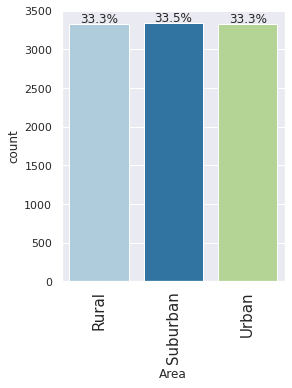

*********************************************


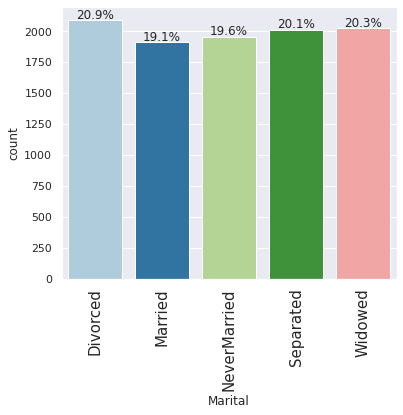

*********************************************


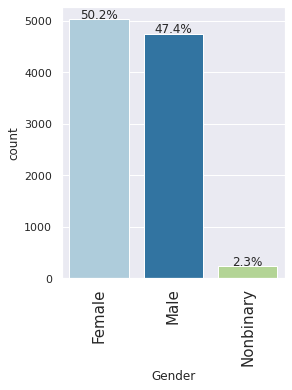

*********************************************


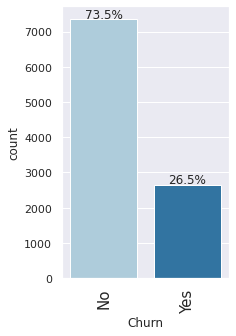

*********************************************


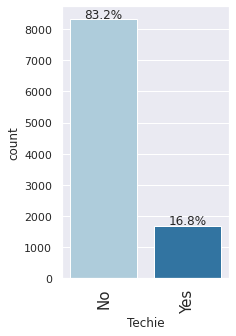

*********************************************


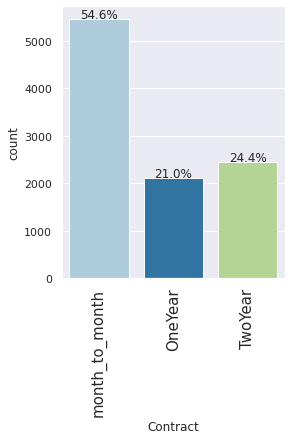

*********************************************


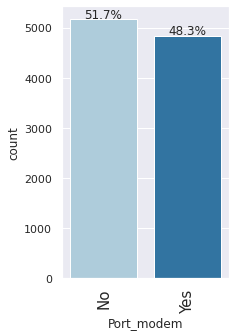

*********************************************


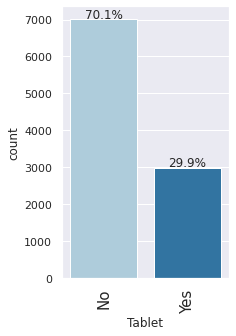

*********************************************


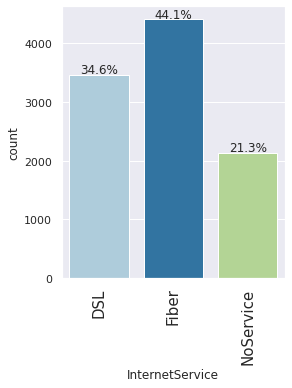

*********************************************


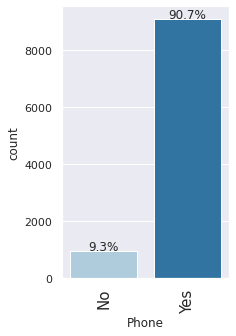

*********************************************


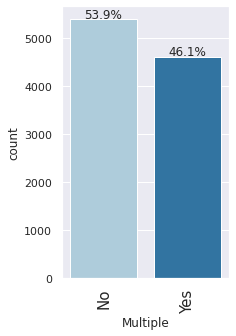

*********************************************


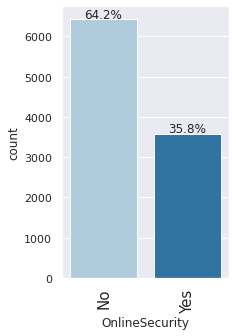

*********************************************


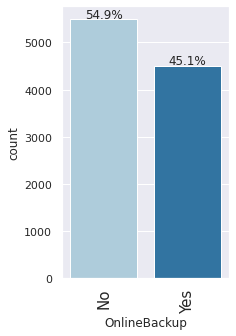

*********************************************


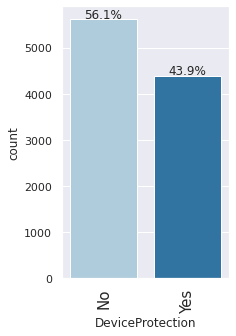

*********************************************


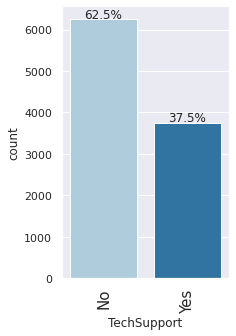

*********************************************


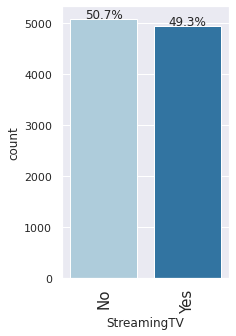

*********************************************


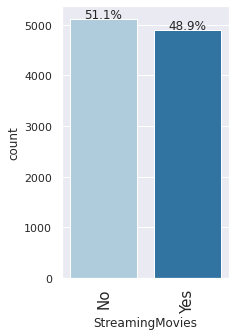

*********************************************


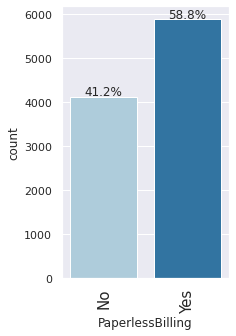

*********************************************


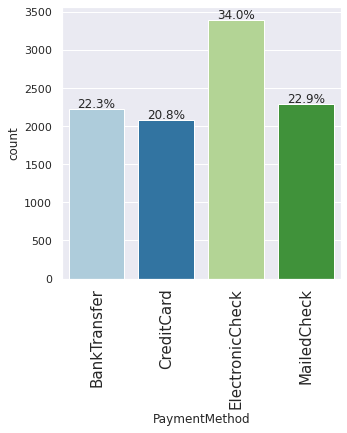

*********************************************


In [25]:
for x in cat_vars:
  labeled_barplot(df, x, perc=True)
  print('*'*45)

#### **Univariate visualization continuous variables**

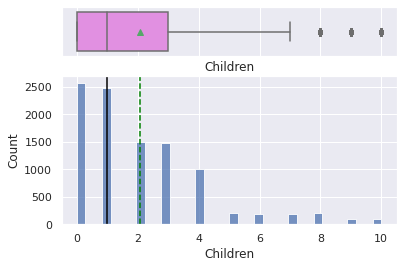

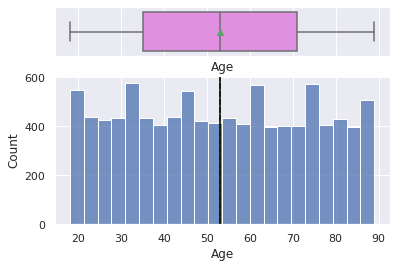

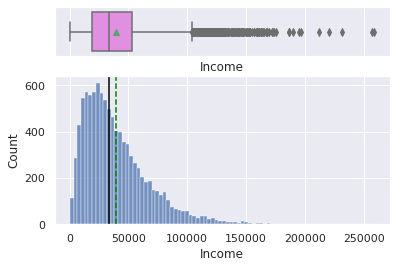

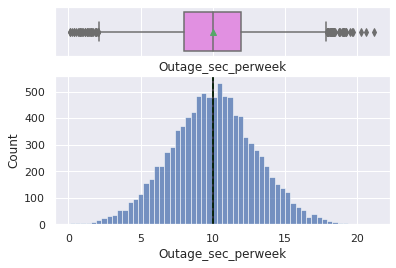

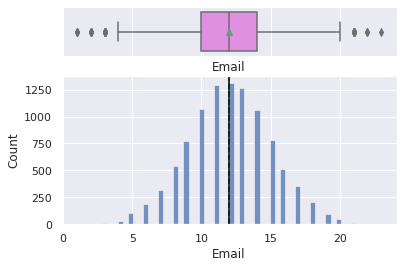

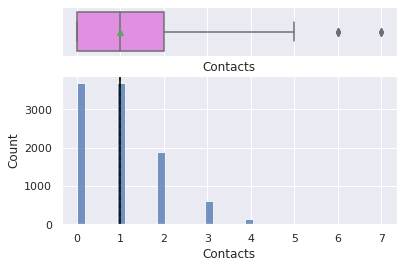

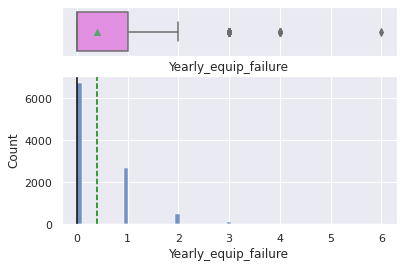

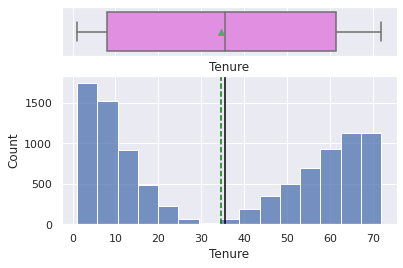

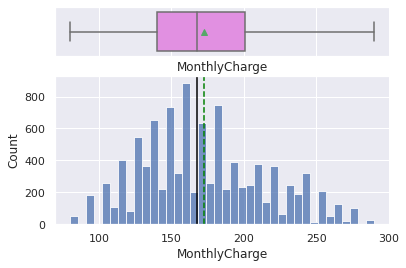

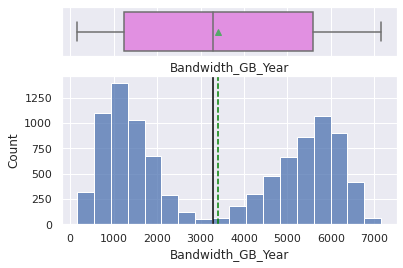

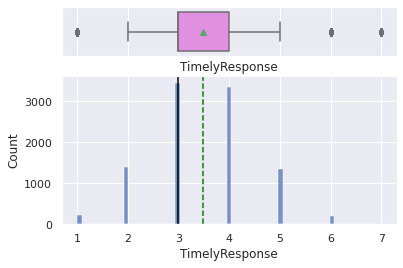

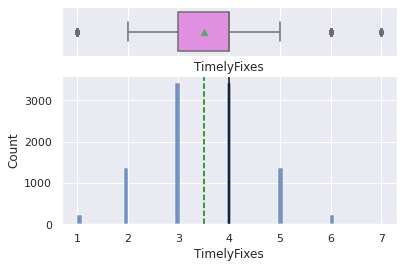

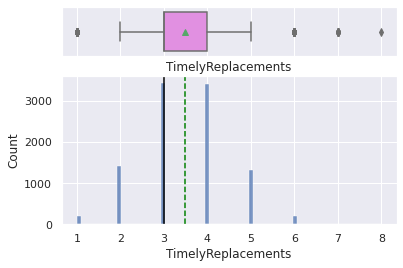

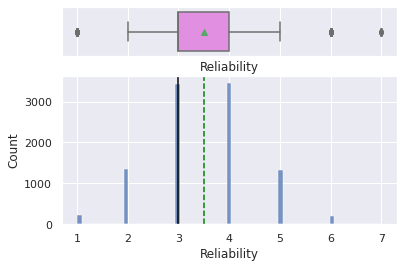

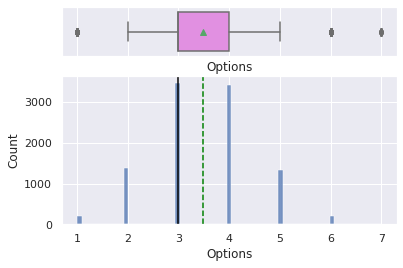

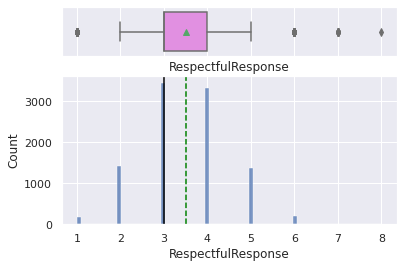

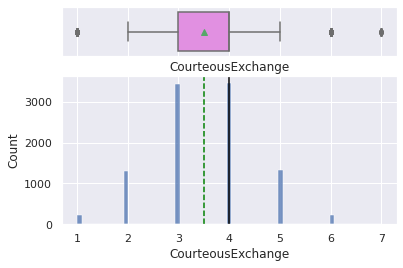

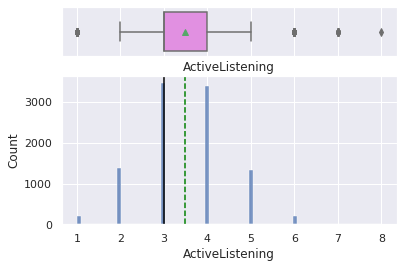

In [26]:
for x in df.columns.to_list():
  if x not in cat_vars:
    histogram_boxplot(df, x)
    

##**Bivariate Visualization**

###**Heat map ( continuous variables)**

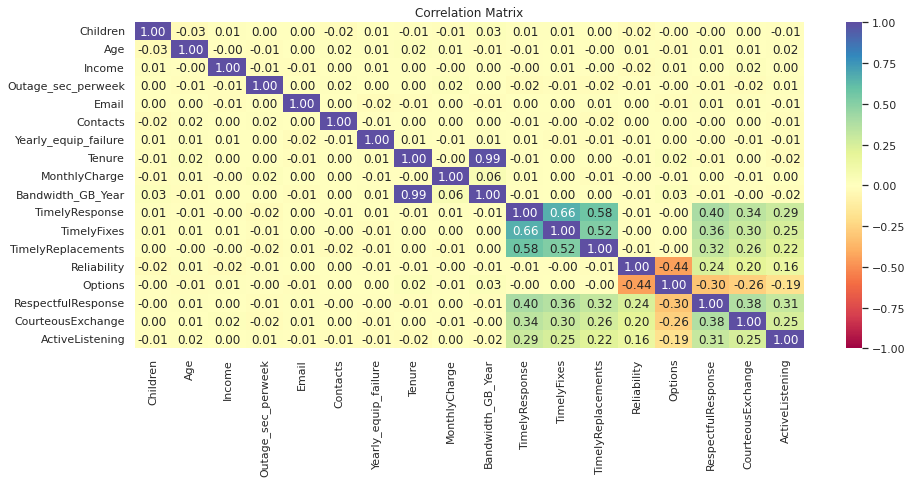

In [27]:
# lets perform correlation
plt.figure(figsize= (15, 6))
correlation = df.corr()
sns.heatmap(correlation, annot= True,vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.title("Correlation Matrix")
plt.show()

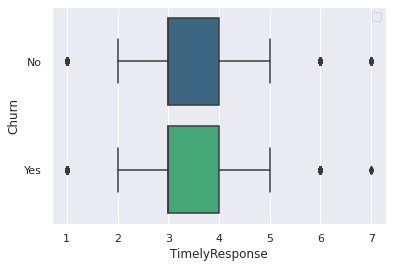

In [67]:
plt.figure(figsize=(6,4))
sns.boxplot(df.TimelyResponse,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

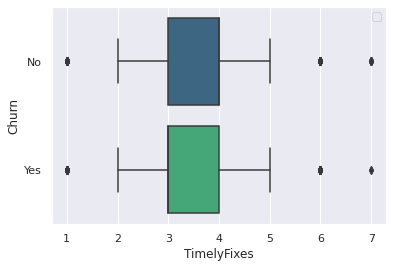

In [77]:
plt.figure(figsize=(6,4))
sns.boxplot(df.TimelyFixes,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

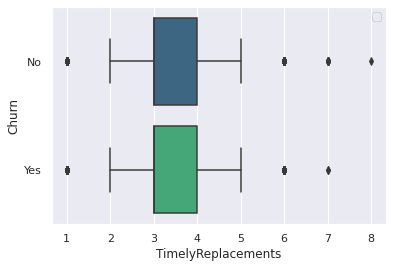

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(df.TimelyReplacements,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

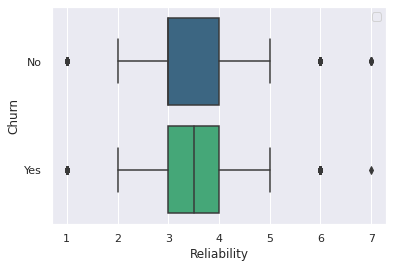

In [79]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Reliability,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

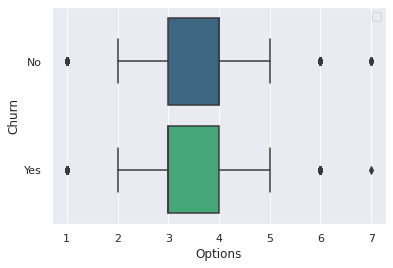

In [80]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Options,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

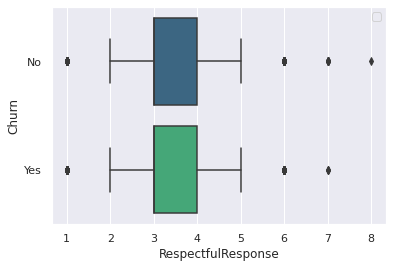

In [82]:
plt.figure(figsize=(6,4))
sns.boxplot(df.RespectfulResponse,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

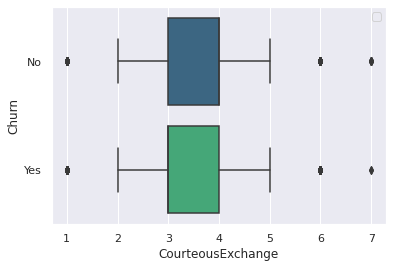

In [85]:
plt.figure(figsize=(6,4))
sns.boxplot(df.CourteousExchange,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

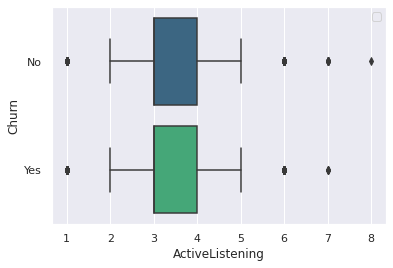

In [87]:
plt.figure(figsize=(6,4))
sns.boxplot(df.ActiveListening,df.Churn,palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

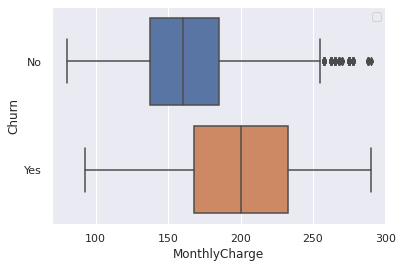

In [88]:
plt.figure(figsize=(6,4))
sns.boxplot(df.MonthlyCharge,df.Churn,)
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

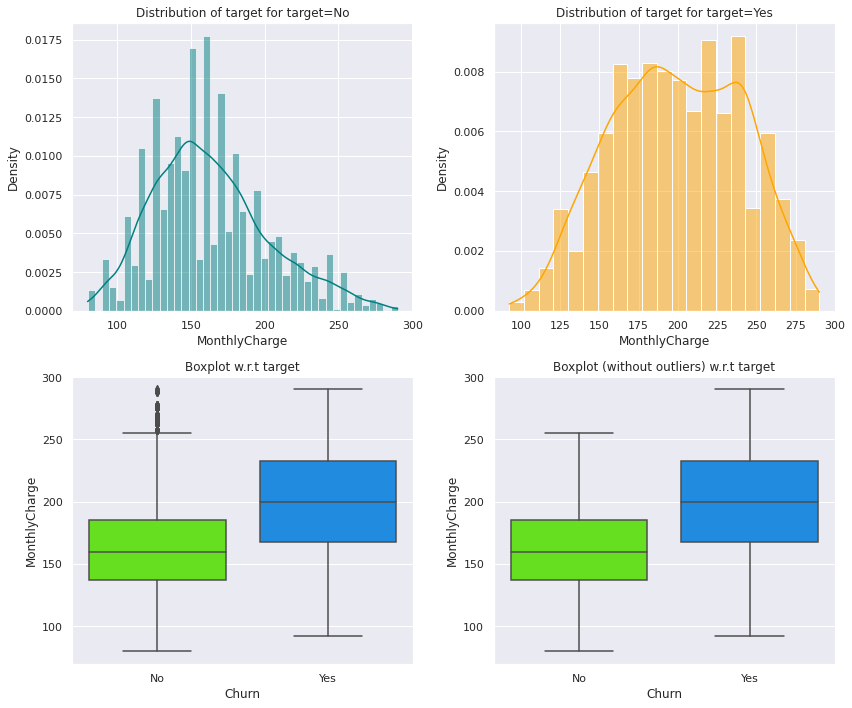

In [89]:
distribution_plot_wrt_target(df, "MonthlyCharge", "Churn")

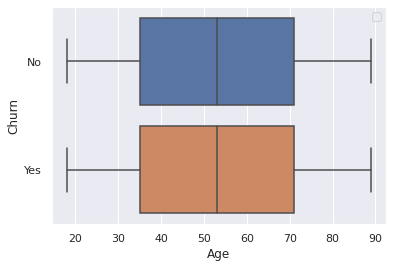

In [73]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Age,df.Churn)
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

In [ ]:
distribution_plot_wrt_target(df, "MonthlyCharge", "Churn")

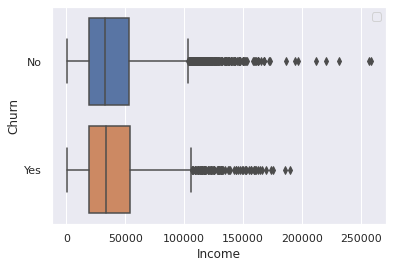

In [74]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Income,df.Churn)
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

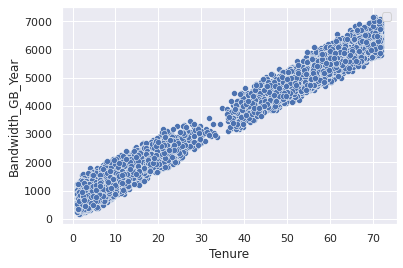

In [39]:
plt.figure(figsize=(6,4))
sns.scatterplot(df.Tenure, df.Bandwidth_GB_Year,ci=0)
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

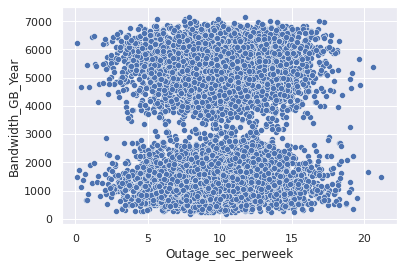

In [40]:
plt.figure(figsize=(6,4))
sns.scatterplot(df.Outage_sec_perweek,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

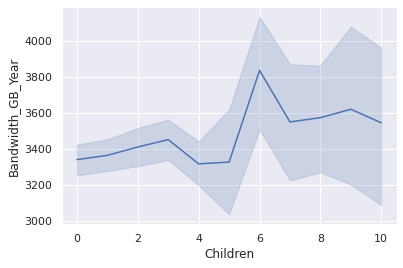

In [41]:
plt.figure(figsize=(6,4))
sns.lineplot(df.Children,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

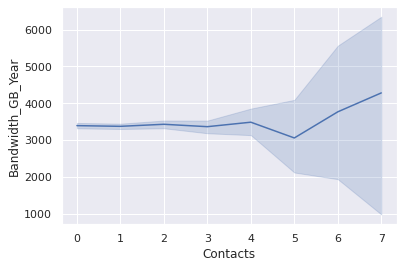

In [42]:
plt.figure(figsize=(6,4))
sns.lineplot(df.Contacts,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

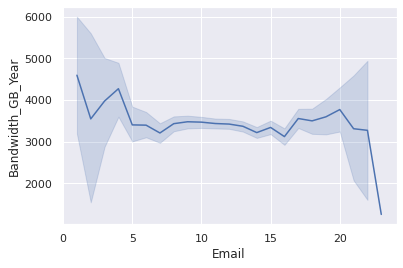

In [43]:
plt.figure(figsize=(6,4))
sns.lineplot(df.Email,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

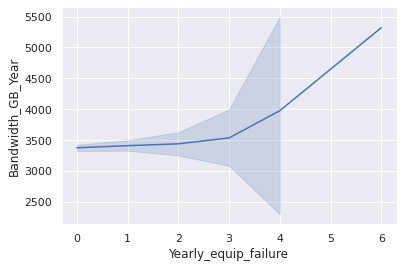

In [44]:
plt.figure(figsize=(6,4))
sns.lineplot(df.Yearly_equip_failure,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

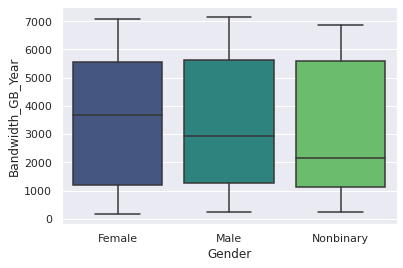

In [45]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Gender,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

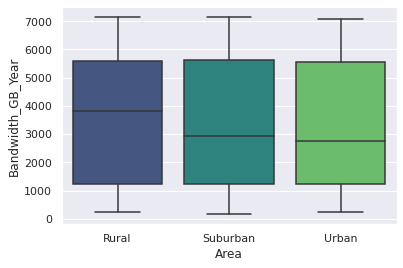

In [46]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Area,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

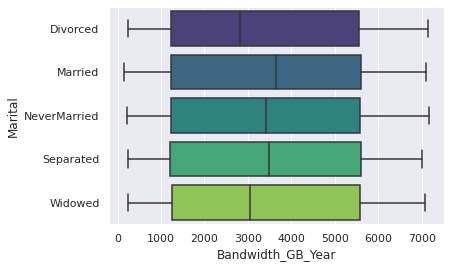

In [47]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Bandwidth_GB_Year,df.Marital,palette="viridis")
plt.show()

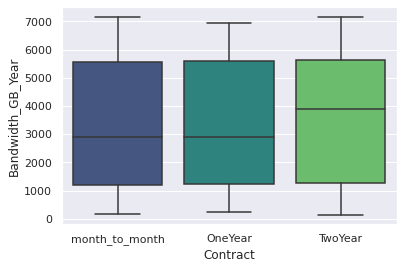

In [48]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Contract,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

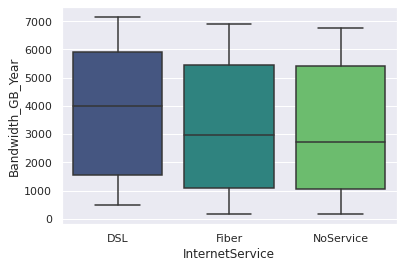

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(df.InternetService,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

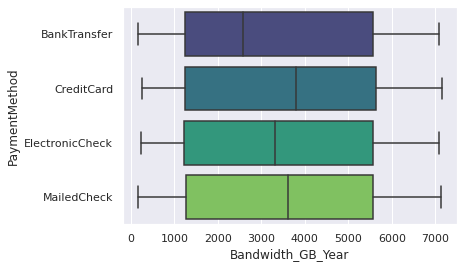

In [50]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Bandwidth_GB_Year,df.PaymentMethod,palette="viridis")
plt.show()

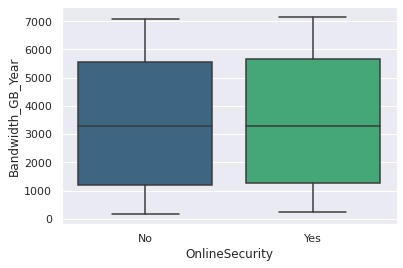

In [51]:
plt.figure(figsize=(6,4))
sns.boxplot(df.OnlineSecurity,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

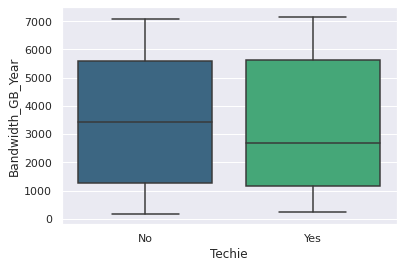

In [52]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Techie,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

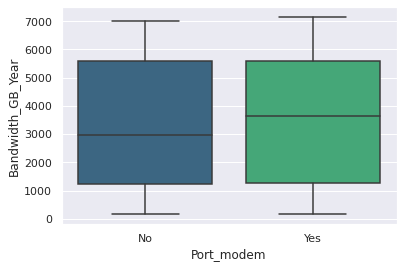

In [53]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Port_modem,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

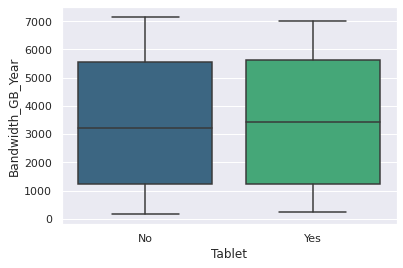

In [54]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Tablet,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

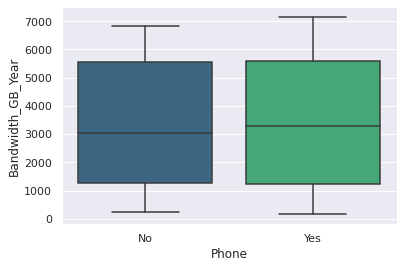

In [55]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Phone,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

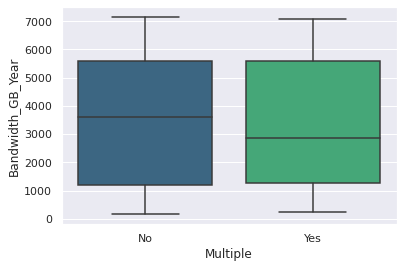

In [56]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Multiple,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

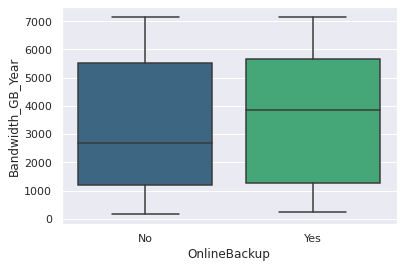

In [57]:
plt.figure(figsize=(6,4))
sns.boxplot(df.OnlineBackup,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

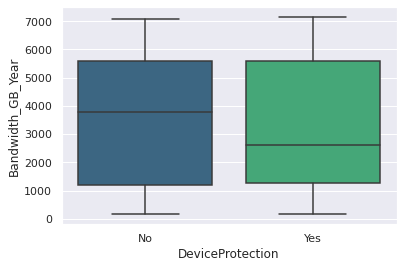

In [58]:
plt.figure(figsize=(6,4))
sns.boxplot(df.DeviceProtection,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

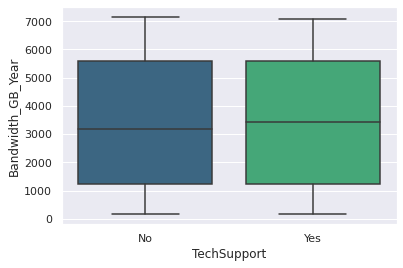

In [59]:
plt.figure(figsize=(6,4))
sns.boxplot(df.TechSupport,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

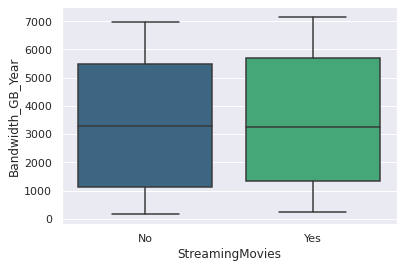

In [60]:
plt.figure(figsize=(6,4))
sns.boxplot(df.StreamingMovies,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

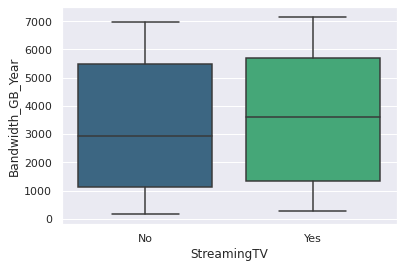

In [61]:
plt.figure(figsize=(6,4))
sns.boxplot(df.StreamingTV,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

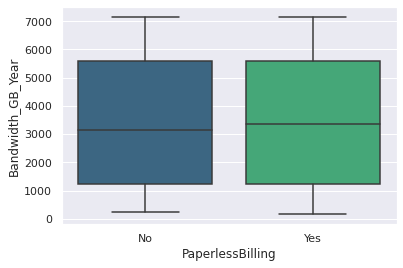

In [62]:
plt.figure(figsize=(6,4))
sns.boxplot(df.PaperlessBilling,df.Bandwidth_GB_Year,palette="viridis")
plt.show()

In [63]:
cols_totreat =['Children','Income','Outage_sec_perweek','Email','Contacts','Yearly_equip_failure',
               'TimelyResponse','TimelyFixes','TimelyReplacements','Reliability','Options',
               'RespectfulResponse','CourteousExchange','ActiveListening']

In [64]:
#Getting dummy variables for categorical columns
#df = pd.get_dummies(df, drop_first=True)

#making a copy of the prepared dataset and extract a copy for submission

#churn_df =  df.copy()

 

In [65]:
#churn_df.to_csv('prepared_churn.csv')

In [66]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    """ Based on features , generate correlation matrix """
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(20,10))
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)
    plt.show()
var_corr = round(churn_df.corr(),2)
Generate_heatmap_graph(var_corr
                       ,chart_title = 'Correlation Heatmap'
                       ,mask_uppertri = True)

NameError: ignored

In [ ]:
churn = df.copy()

In [ ]:
churn_df.info()

# **Model  Comparsion and analysis**
## **Model ONE All features**

In [ ]:
X = churn_df.drop(["Bandwidth_GB_Year"], axis=1)
y = churn_df["Bandwidth_GB_Year"]



# **Model  Comparsion and analysis**
## **Model 2 Reduced features**